In [ ]:
# divide order ratio and average cost into 3 stages(before disruption, after disruption but no strategy applied, after strategy(done)
# compare gap_based mode and recorder based mode(normal state and disruption state) (done)
# difference correction define in simulator(done)

# order created in disruption period, but delievered in strategy period, cost and ratio calculated in strategy period (long simulation step?)
# different period influence each other in a long time, compare different strategy in different parameter combination scenerials would be better? 
#(strategy influence is quite limited unless change the disruption parameter itself)









In [1]:
import random
import numpy as np
import math
import mesa
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import BaseScheduler
import pandas as pd
from SCN.agent import Order, Customer, Manufacturer, Supplier, manhattan_distance
from SCN.model import update_transport_cost_for_order, random_position_unique, SupplyChainGridModel,calculate_unit_cost

In [2]:
df = pd.read_csv("SCN/supply_chain_data.csv")
df.rename(columns={"Stock levels": "inventory"}, inplace=True)
df["inventory"] = df["inventory"].apply(lambda x: math.ceil(x) if pd.notnull(x) else x)
df["Order quantities"] = df["Order quantities"].apply(lambda x: math.ceil(x) if pd.notnull(x) else x)
df = df[["inventory", "Order quantities"]]
inventory_count = df["inventory"].count()
order_qty_count = df["Order quantities"].count()
print("inventory 列数据个数（非空）:", inventory_count)
print("Order quantities 列数据个数（非空）:", order_qty_count)
print(df.head())
demands_list = df["Order quantities"].dropna().tolist()
inventory_list = df["inventory"].dropna().astype(int).tolist()
inventory_mean = df["inventory"].mean()
order_qty_mean = df["Order quantities"].mean()

print(f"Inventory 列的均值: {inventory_mean}")
print(f"Order quantities 列的均值: {order_qty_mean}")

inventory 列数据个数（非空）: 100
Order quantities 列数据个数（非空）: 100
   inventory  Order quantities
0         58                96
1         53                37
2          1                88
3         23                59
4          5                56
Inventory 列的均值: 47.77
Order quantities 列的均值: 49.22


In [3]:
df = pd.read_csv("SCN/DataCoSupplyChainDataset.csv", encoding="latin1")
df = df[["Customer Id", "Latitude", "Longitude"]]
df_unique = df.drop_duplicates()
df_sample = df_unique.sample(n=20, random_state=43)

# 3. 先利用 rank 得到初始坐标，保证原始数据不同对应不同数值
df_sample["x"] = df_sample["Latitude"].rank(method="dense", ascending=True).astype(int)
df_sample["y"] = df_sample["Longitude"].rank(method="dense", ascending=True).astype(int)

# 4. 将坐标缩放：简单的除以2，再取整，使数值变小
df_sample["x"] = np.ceil(df_sample["x"] / 2).astype(int)
df_sample["y"] = np.ceil(df_sample["y"] / 2).astype(int)

# 5. 去重：若缩放后出现多个点落在同一格，则只保留一条记录
df_final = df_sample.drop_duplicates(subset=["x", "y"])

# 6. 查看结果
print(df_final[["Customer Id", "Latitude", "Longitude", "x", "y"]])
print("Number of rows in df_final:", df_final.shape[0])
positions = df_final[["x", "y"]].values.tolist()

        Customer Id   Latitude   Longitude   x   y
55375          1672  34.077606 -117.240181   6   2
7248           4567  18.210739  -66.370605   1   8
16153         14473  38.611774 -121.282867   7   1
97197         17450  26.145800  -97.958252   4   3
71502         15468  34.748348  -77.428482   6   6
120672        12651  40.763580  -73.830040  10   7
26189          8613  18.285648  -66.370613   3   8
34169         16312  40.508579  -88.982643   9   5
23487         17513  40.575642  -73.995209   9   7
88976         19990  33.089520 -117.255203   5   1
3550           3223  18.228659  -66.370560   3   9
37418          3400  33.947170 -117.253624   5   2
26483         12591  18.212404  -66.037056   1  10
18823         11606  35.731037  -78.855751   7   5
8436           9658  29.696537  -95.645920   4   4
17043         14253  38.796600  -90.346405   8   4
25600          1953  39.000355  -77.227814   8   6
70368         13329  41.274368 -111.962868  10   3
7940           8915  18.216906 

In [7]:
import networkx as nx

def get_weighted_edge_count(model):
    """
    构建一个 MultiGraph，将模型中所有代理作为节点，
    对于每个 delivered_orders 中已完成且已发货的订单，
    在发货方和收货方之间添加一条边，边的权重为订单数量。
    返回图中所有边的权重和，即为 weighted edge count。
    """
    G = nx.MultiGraph()
    for agent in model.schedule.agents:
        G.add_node(agent.unique_id)
    for order in model.delivered_orders:
        if order.completed and order.shipped and order.order_type == "product":
            # 添加边时指定 weight 属性为订单数量
            G.add_edge(order.sender_id, order.receiver_id, weight=order.quantity)
    total_weight = sum(data.get('weight', 1) for u, v, data in G.edges(data=True))
    return total_weight


In [8]:
def run_simulation_with_param_changes(
        heterogeneous=False,
        cust_demand_multiplier=1.0,
        m_production_capacity=10,
        m_inventory_capacity_product=400,
        m_inventory_capacity_material=800,
        s_material_capacity=300,
        m_cap_mode="homogeneous",
        logistics_speed=1.0,
        rm_procurement_mode="gap_based",
        rm_reorder_point=30,
        rm_reorder_target=500,
        rm_purchase_multiplier=1.8,
        rm_produce_multiplier=1.7,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=1000,
        num_reps=2,
        change_schedule=None,
        return_model=False):
    """
    运行 num_reps 次仿真，并在运行过程中按 change_schedule 更新参数。
    最终返回：(
      mean_prod_ratio,       # 整体订单时效比均值（可删）
      mean_unit_cost,        # 整体单位供应链成本均值（可删）
      mean_edge_series,
      std_edge_series,
      phase_metrics          # 各阶段 (时效比, 单位成本, 完成量)
    )
    """
    ratio_prod_list = []
    unit_cost_list = []
    weighted_edge_count_list = []

    for rep in range(num_reps):
        # 清空全局 used_positions
        try:
            from SCN.agent import used_positions
            used_positions.clear()
        except:
            pass

        # 初始化模型
        model = SupplyChainGridModel(
            positions=positions,
            demands_list=demands_list,
            inventory_list=inventory_list,
            num_customers=10,
            num_manufacturers=6,
            num_suppliers=3,
            cust_demand_probability=0.4,
            cust_demand_multiplier=cust_demand_multiplier,
            m_production_capacity=m_production_capacity,
            m_inventory_capacity_product=m_inventory_capacity_product,
            m_inventory_capacity_material=m_inventory_capacity_material,
            s_material_capacity=s_material_capacity,
            m_cap_mode=m_cap_mode,
            logistics_speed=logistics_speed,
            rm_procurement_mode=rm_procurement_mode,
            rm_reorder_point=rm_reorder_point,
            rm_reorder_target=rm_reorder_target,
            rm_purchase_multiplier=rm_purchase_multiplier,
            rm_produce_multiplier=rm_produce_multiplier,
            product_order_mode=product_order_mode,
            material_order_mode=material_order_mode
        )

        # 加权边数容器
        rep_edge_series = []

        # 构造变化点列表（只保留 <= total_steps）
        if change_schedule:
            points = sorted(p for p in change_schedule if 0 < p <= total_steps)
        else:
            points = []
        # 最后一个阶段终点
        points.append(total_steps)
        # 快照队列，初始值(0,0,0,0)
        snapshots = [(0, 0, 0, 0)]
        next_change_index = 0

        # 主循环：每个时间步
        for current_step in range(1, total_steps+1):
            # 执行一步
            model.step()

            # 累积 weighted_edge_count
            # （此处假设你在 step 中向 rep_edge_series 中追加了当步数值）
            rep_edge_series.append(get_weighted_edge_count(model))

            # 参数动态更新
            if change_schedule and current_step in change_schedule:
                changes = change_schedule[current_step]
                # Customer
                if "product_order_mode" in changes:
                    for c in model.customers:
                        c.order_mode = changes["product_order_mode"]
                if "cust_demand_multiplier" in changes:
                    for c in model.customers:
                        c.cust_demand_multiplier = changes["cust_demand_multiplier"]
                # 全局
                if "logistics_speed" in changes:
                    model.logistics_speed = changes["logistics_speed"]
                # Manufacturer
                if "m_production_capacity" in changes:
                    for m in model.manufacturers:
                        m.production_capacity = changes["m_production_capacity"]
                if "rm_procurement_mode" in changes:
                    for m in model.manufacturers:
                        m.rm_procurement_mode = changes["rm_procurement_mode"]
                if "rm_purchase_multiplier" in changes:
                    for m in model.manufacturers:
                        m.rm_purchase_multiplier = changes["rm_purchase_multiplier"]
                if "material_order_mode" in changes:
                    for m in model.manufacturers:
                        m.material_order_mode = changes["material_order_mode"]
                # Supplier
                if "s_material_capacity" in changes:
                    for s in model.suppliers:
                        s.material_capacity = changes["s_material_capacity"]

            # 到达阶段终点，采集快照
            if current_step == points[next_change_index]:
                # 产品订单快照
                prod_orders = [
                    o for o in model.delivered_orders
                    if o.order_type == "product" and o.actual_delivery_time is not None
                ]
                sum_act  = sum(o.actual_delivery_time   for o in prod_orders)
                sum_theo = sum(o.theoretical_delivery_time for o in prod_orders)
                # 制造商累计成本与完成量
                total_cost = sum(
                    m.cumulative_storage_cost_product +
                    m.cumulative_storage_cost_material +
                    m.cumulative_transport_cost +
                    m.cumulative_penalty_cost
                    for m in model.manufacturers
                )
                total_comp = sum(m.completed_products for m in model.manufacturers)

                snapshots.append((sum_act, sum_theo, total_cost, total_comp))
                next_change_index += 1

        # 记录本次 rep 的序列
        weighted_edge_count_list.append(rep_edge_series)

        # （可选）整体指标
        # 订单整体时效比
        sum_act  = sum(o.actual_delivery_time   for o in model.delivered_orders
                       if o.order_type == "product" and o.actual_delivery_time is not None)
        sum_theo = sum(o.theoretical_delivery_time for o in model.delivered_orders
                       if o.order_type == "product" and o.actual_delivery_time is not None)
        ratio_prod = sum_act / sum_theo if sum_theo > 0 else 0
        ratio_prod_list.append(ratio_prod)
        # 整体单位供应链成本
        uc = calculate_unit_cost(model)
        unit_cost_list.append(uc if uc is not None else 0.0)

    # across reps 的加权边数均值与 std
    edge_arr = np.array(weighted_edge_count_list)
    mean_edge = np.mean(edge_arr, axis=0)
    std_edge  = np.std(edge_arr, axis=0)

    # 逐段计算指标
    phase_metrics = []
    for i in range(len(snapshots)-1):
        a0, t0, c0, p0 = snapshots[i]
        a1, t1, c1, p1 = snapshots[i+1]
        da, dt, dc, dp = a1-a0, t1-t0, c1-c0, p1-p0
        r = da/dt if dt>0 else 0
        uc_phase = dc/dp if dp>0 else 0
        phase_metrics.append((r, uc_phase, dp))

    results = (
        np.mean(ratio_prod_list),  # 可删
        np.mean(unit_cost_list),   # 可删
        mean_edge,
        std_edge,
        phase_metrics
    )
    return (model, results) if return_model else results

Running scenario: Strategy A
—— Per-Phase Metrics for Strategy A ——
 Step   200:   Ratio = 5.224,   UnitCost = 99.014,   Completed = 35789.0
 Step  3000:   Ratio = 61.620,   UnitCost = 1264.943,   Completed = 114609.0
Running scenario: Strategy B
—— Per-Phase Metrics for Strategy B ——
 Step   200:   Ratio = 4.430,   UnitCost = 83.543,   Completed = 35785.0
 Step  1000:   Ratio = 43.382,   UnitCost = 943.906,   Completed = 33304.0
 Step  3000:   Ratio = 71.554,   UnitCost = 1517.221,   Completed = 89253.0
Running scenario: Strategy C
—— Per-Phase Metrics for Strategy C ——
 Step   200:   Ratio = 5.000,   UnitCost = 95.695,   Completed = 35946.0
 Step  1000:   Ratio = 51.162,   UnitCost = 1074.358,   Completed = 37095.0
 Step  3000:   Ratio = 69.768,   UnitCost = 1452.526,   Completed = 89915.0
Running scenario: Strategy D
—— Per-Phase Metrics for Strategy D ——
 Step   200:   Ratio = 5.496,   UnitCost = 103.481,   Completed = 37444.0
 Step  1000:   Ratio = 47.404,   UnitCost = 974.062,   

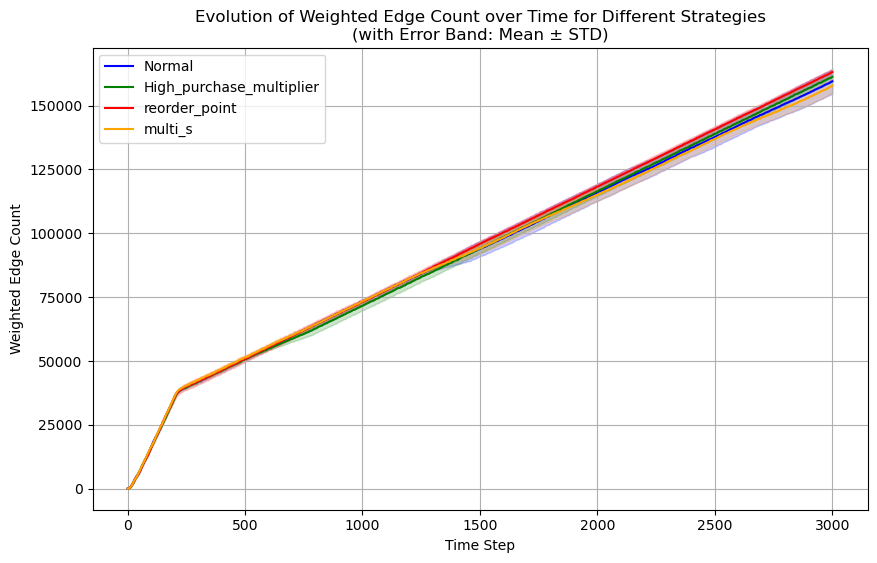

In [18]:
change_schedule_A = {
    200: {"s_material_capacity": 30}
}
change_schedule_B = {
    200: {"s_material_capacity": 30},
    1000: {"rm_purchase_multiplier": 2}
}
change_schedule_C = {
    200: {"s_material_capacity": 30},
    1000: {"rm_procurement_mode": "reorder_point"}
}
change_schedule_D = {
    200: {"s_material_capacity": 30},
    1000: {"material_order_mode":"multi_s"}
}
total_steps = 3000

def run_scenario(scenario_name, change_schedule):
    print(f"Running scenario: {scenario_name}")
    results = run_simulation_with_param_changes(
        heterogeneous=True,
        cust_demand_multiplier=1.0,
        m_production_capacity=50,
        m_inventory_capacity_product=300,
        m_inventory_capacity_material=600,
        s_material_capacity=150,
        m_cap_mode="heterogeneous",  # 这里可以选择 "heterogeneous" 或其他模式
        logistics_speed=2.0,
        rm_procurement_mode="gap_based",
        rm_reorder_point=100,
        rm_reorder_target=300,
        rm_purchase_multiplier=1.2,
        rm_produce_multiplier=1.1,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=3000,
        num_reps=5,
        change_schedule=change_schedule,
        return_model=False
    )
    # 这里 results = (mean_prod_ratio, mean_unit_cost, mean_weighted_edge_count)
    mean_prod_ratio, mean_unit_cost, mean_edge_series, std_edge_series, phase_metrics = results

     # 按变更点打印每一段的指标
    points = sorted([p for p in change_schedule.keys() if p <= total_steps] + [total_steps])
    print(f"—— Per-Phase Metrics for {scenario_name} ——")
    for idx, step in enumerate(points):
        r, uc_phase, completed_count = phase_metrics[idx]
        print(f" Step {step:>5}:   Ratio = {r:.3f},   UnitCost = {uc_phase:.3f},   Completed = {completed_count}")
    return mean_prod_ratio, mean_unit_cost, mean_edge_series, std_edge_series, phase_metrics

# 分别运行 4 个不同场景
results_A = run_scenario("Strategy A", change_schedule_A)
results_B = run_scenario("Strategy B", change_schedule_B)
results_C = run_scenario("Strategy C", change_schedule_C)
results_D = run_scenario("Strategy D", change_schedule_D)

time_steps = np.arange(1, total_steps + 1)

# 从各个策略的 simulation 返回结果中提取 weighted edge count 的均值和标准差
# 假设 run_scenario 返回的结果格式为：
# (mean_cap, mean_prod_ratio, mean_statusN, mean_unit_cost, mean_edge_series, std_edge_series)
mean_edge_series_A = results_A[2]
std_edge_series_A = results_A[3]

mean_edge_series_B = results_B[2]
std_edge_series_B = results_B[3]

mean_edge_series_C = results_C[2]
std_edge_series_C = results_C[3]

mean_edge_series_D = results_D[2]
std_edge_series_D = results_D[3]

plt.figure(figsize=(10, 6))

# 绘制 Strategy A 的曲线和误差带
plt.plot(time_steps, mean_edge_series_A, label="Normal", color="blue")
plt.fill_between(time_steps,
                 mean_edge_series_A - std_edge_series_A,
                 mean_edge_series_A + std_edge_series_A,
                 color="blue", alpha=0.2)

# 绘制 Strategy B 的曲线和误差带
plt.plot(time_steps, mean_edge_series_B, label="High_purchase_multiplier", color="green")
plt.fill_between(time_steps,
                 mean_edge_series_B - std_edge_series_B,
                 mean_edge_series_B + std_edge_series_B,
                 color="green", alpha=0.2)

# 绘制 Strategy C 的曲线和误差带
plt.plot(time_steps, mean_edge_series_C, label="reorder_point", color="red")
plt.fill_between(time_steps,
                 mean_edge_series_C - std_edge_series_C,
                 mean_edge_series_C + std_edge_series_C,
                 color="red", alpha=0.2)

# 绘制 Strategy D 的曲线和误差带
plt.plot(time_steps, mean_edge_series_D, label="multi_s", color="orange")
plt.fill_between(time_steps,
                 mean_edge_series_D - std_edge_series_D,
                 mean_edge_series_D + std_edge_series_D,
                 color="orange", alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Evolution of Weighted Edge Count over Time for Different Strategies\n(with Error Band: Mean ± STD)")
plt.legend()
plt.grid(True)
plt.show()

=== Scenario: rm_procurement_mode = gap_based ===
Overall production ratio: 5.388
Overall unit cost:       99.421

=== Scenario: rm_procurement_mode = reorder_point ===
Overall production ratio: 3.620
Overall unit cost:       66.721



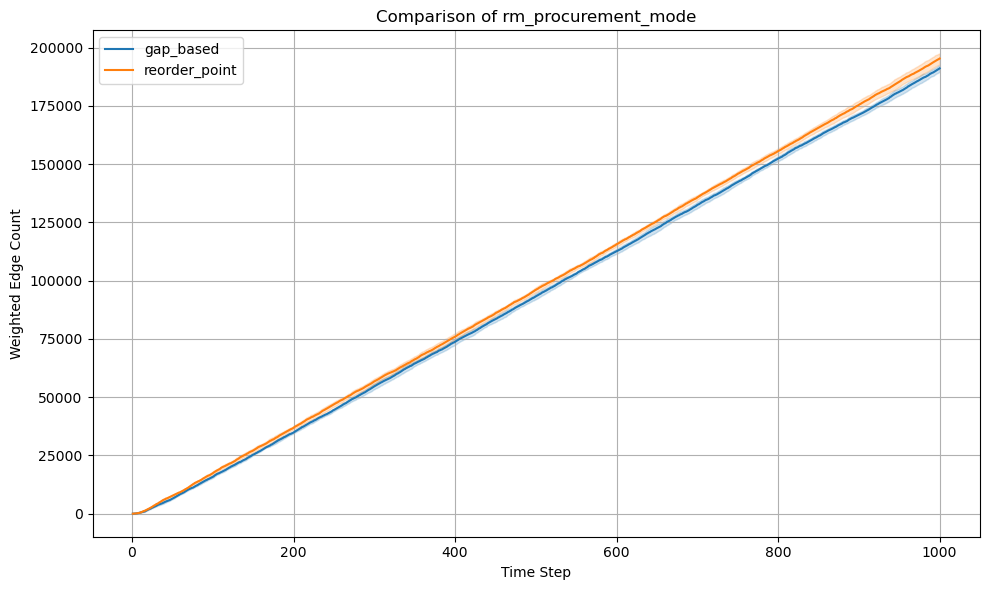

In [13]:
# compare rm_procurement_mode(gap_based VS reorder_point in normal scenario)
# 公共参数
common_params = dict(
    heterogeneous=True,
    cust_demand_multiplier=1.0,
    m_production_capacity=50,
    m_inventory_capacity_product=300,
    m_inventory_capacity_material=600,
    s_material_capacity=150,
    m_cap_mode="heterogeneous",
    logistics_speed=2.0,
    # 这两个会在下面覆盖
    # rm_procurement_mode="gap_based",
    rm_reorder_point=100,
    rm_reorder_target=300,
    rm_purchase_multiplier=1.2,
    rm_produce_multiplier=1.1,
    product_order_mode="normal",
    material_order_mode="normal",
    total_steps=1000,
    num_reps=5,           # 建议多跑几次以估计 std
    change_schedule={},    # 本例无中途策略切换
    return_model=False
)

# 运行 gap_based
params_A = common_params.copy()
params_A["rm_procurement_mode"] = "gap_based"
print("=== Scenario: rm_procurement_mode = gap_based ===")
ratio_A, uc_A, mean_A, std_A, _ = run_simulation_with_param_changes(**params_A)
print(f"Overall production ratio: {ratio_A:.3f}")
print(f"Overall unit cost:       {uc_A:.3f}\n")

# 运行 reorder_point
params_B = common_params.copy()
params_B["rm_procurement_mode"] = "reorder_point"
print("=== Scenario: rm_procurement_mode = reorder_point ===")
ratio_B, uc_B, mean_B, std_B, _ = run_simulation_with_param_changes(**params_B)
print(f"Overall production ratio: {ratio_B:.3f}")
print(f"Overall unit cost:       {uc_B:.3f}\n")

# X 轴刻度
time_steps = np.arange(1, common_params["total_steps"] + 1)

# 画图：加权边数 Mean ± STD
plt.figure(figsize=(10,6))
plt.plot(time_steps, mean_A, label="gap_based", color="C0")
plt.fill_between(time_steps,
                 mean_A - std_A,
                 mean_A + std_A,
                 color="C0", alpha=0.2)
plt.plot(time_steps, mean_B, label="reorder_point", color="C1")
plt.fill_between(time_steps,
                 mean_B - std_B,
                 mean_B + std_B,
                 color="C1", alpha=0.2)
plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Comparison of rm_procurement_mode")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

=== Scenario: rm_procurement_mode = gap_based ===
Overall production ratio: 55.006
Overall unit cost:       1146.922

=== Scenario: rm_procurement_mode = reorder_point ===
Overall production ratio: 52.345
Overall unit cost:       1103.926



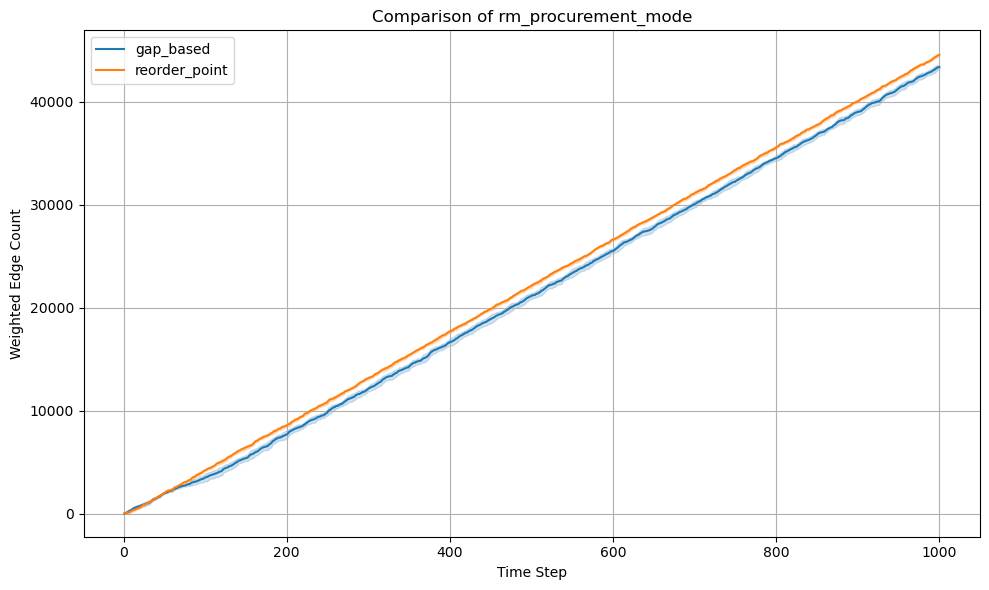

In [14]:
# compare rm_procurement_mode(gap_based VS reorder_point in material shortage disruption scenario)
# 公共参数
common_params = dict(
    heterogeneous=True,
    cust_demand_multiplier=1.0,
    m_production_capacity=50,
    m_inventory_capacity_product=300,
    m_inventory_capacity_material=600,
    s_material_capacity=30,
    m_cap_mode="heterogeneous",
    logistics_speed=2.0,
    # 这两个会在下面覆盖
    # rm_procurement_mode="gap_based",
    rm_reorder_point=100,
    rm_reorder_target=300,
    rm_purchase_multiplier=1.2,
    rm_produce_multiplier=1.1,
    product_order_mode="normal",
    material_order_mode="normal",
    total_steps=1000,
    num_reps=5,           # 建议多跑几次以估计 std
    change_schedule={},    # 本例无中途策略切换
    return_model=False
)

# 运行 gap_based
params_A = common_params.copy()
params_A["rm_procurement_mode"] = "gap_based"
print("=== Scenario: rm_procurement_mode = gap_based ===")
ratio_A, uc_A, mean_A, std_A, _ = run_simulation_with_param_changes(**params_A)
print(f"Overall production ratio: {ratio_A:.3f}")
print(f"Overall unit cost:       {uc_A:.3f}\n")

# 运行 reorder_point
params_B = common_params.copy()
params_B["rm_procurement_mode"] = "reorder_point"
print("=== Scenario: rm_procurement_mode = reorder_point ===")
ratio_B, uc_B, mean_B, std_B, _ = run_simulation_with_param_changes(**params_B)
print(f"Overall production ratio: {ratio_B:.3f}")
print(f"Overall unit cost:       {uc_B:.3f}\n")

# X 轴刻度
time_steps = np.arange(1, common_params["total_steps"] + 1)

# 画图：加权边数 Mean ± STD
plt.figure(figsize=(10,6))
plt.plot(time_steps, mean_A, label="gap_based", color="C0")
plt.fill_between(time_steps,
                 mean_A - std_A,
                 mean_A + std_A,
                 color="C0", alpha=0.2)
plt.plot(time_steps, mean_B, label="reorder_point", color="C1")
plt.fill_between(time_steps,
                 mean_B - std_B,
                 mean_B + std_B,
                 color="C1", alpha=0.2)
plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Comparison of rm_procurement_mode")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Running scenario: Strategy A
—— Per-Phase Metrics for Strategy A ——
 Step   200:   Ratio = 6.756,   UnitCost = 123.424,   Completed = 32872.0
 Step  3000:   Ratio = 32.406,   UnitCost = 671.490,   Completed = 248311.0
Running scenario: Strategy B
—— Per-Phase Metrics for Strategy B ——
 Step   200:   Ratio = 5.499,   UnitCost = 101.779,   Completed = 32352.0
 Step  1000:   Ratio = 27.572,   UnitCost = 592.071,   Completed = 71077.0
 Step  3000:   Ratio = 30.635,   UnitCost = 664.931,   Completed = 177505.0
Running scenario: Strategy C
—— Per-Phase Metrics for Strategy C ——
 Step   200:   Ratio = 5.556,   UnitCost = 113.324,   Completed = 35689.0
 Step  1000:   Ratio = 24.830,   UnitCost = 557.104,   Completed = 71154.0
 Step  3000:   Ratio = 33.293,   UnitCost = 739.844,   Completed = 177527.0


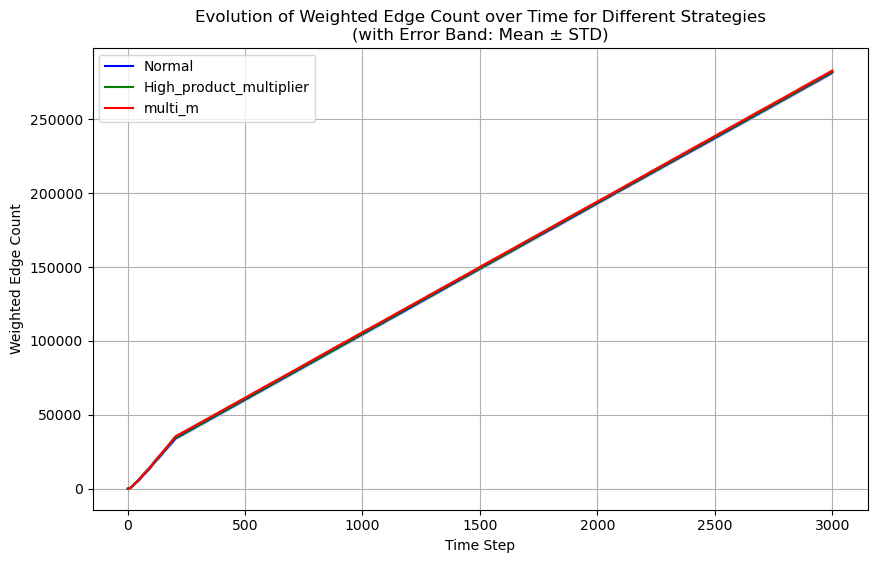

In [19]:
#product capacity change

change_schedule_A = {
    200: {"m_production_capacity": 15}
}
change_schedule_B = {
    200: {"m_production_capacity": 15},
    1000: {"rm_produce_multiplier": 1.5}
}
change_schedule_C = {
    200: {"m_production_capacity": 15},
    1000: {"product_order_mode":"multi_m"}
}


total_steps = 3000

def run_scenario(scenario_name, change_schedule):
    print(f"Running scenario: {scenario_name}")
    results = run_simulation_with_param_changes(
        heterogeneous=True,
        cust_demand_multiplier=1.0,
        m_production_capacity=40,
        m_inventory_capacity_product=300,
        m_inventory_capacity_material=600,
        s_material_capacity=150,
        m_cap_mode="heterogeneous",  # 这里可以选择 "heterogeneous" 或其他模式
        logistics_speed=2.0,
        rm_procurement_mode="gap_based",
        rm_reorder_point=100,
        rm_reorder_target=300,
        rm_purchase_multiplier=1.2,
        rm_produce_multiplier=1.1,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=3000,
        num_reps=5,
        change_schedule=change_schedule,
        return_model=False
    )
    # 这里 results = (mean_prod_ratio, mean_unit_cost, mean_weighted_edge_count)
    mean_prod_ratio, mean_unit_cost, mean_edge_series, std_edge_series, phase_metrics = results

     # 按变更点打印每一段的指标
    points = sorted([p for p in change_schedule.keys() if p <= total_steps] + [total_steps])
    print(f"—— Per-Phase Metrics for {scenario_name} ——")
    for idx, step in enumerate(points):
        r, uc_phase, completed_count = phase_metrics[idx]
        print(f" Step {step:>5}:   Ratio = {r:.3f},   UnitCost = {uc_phase:.3f},   Completed = {completed_count}")
    return mean_prod_ratio, mean_unit_cost, mean_edge_series, std_edge_series, phase_metrics

# 分别运行 3 个不同场景
results_A = run_scenario("Strategy A", change_schedule_A)
results_B = run_scenario("Strategy B", change_schedule_B)
results_C = run_scenario("Strategy C", change_schedule_C)
time_steps = np.arange(1, total_steps + 1)

# 从各个策略的 simulation 返回结果中提取 weighted edge count 的均值和标准差
# 假设 run_scenario 返回的结果格式为：
# (mean_cap, mean_prod_ratio, mean_statusN, mean_unit_cost, mean_edge_series, std_edge_series)
mean_edge_series_A = results_A[2]
std_edge_series_A = results_A[3]

mean_edge_series_B = results_B[2]
std_edge_series_B = results_B[3]

mean_edge_series_C = results_C[2]
std_edge_series_C = results_C[3]

mean_edge_series_D = results_D[2]
std_edge_series_D = results_D[3]

plt.figure(figsize=(10, 6))
# 绘制 Strategy A 的曲线和误差带
plt.plot(time_steps, mean_edge_series_A, label="Normal", color="blue")
plt.fill_between(time_steps,
                 mean_edge_series_A - std_edge_series_A,
                 mean_edge_series_A + std_edge_series_A,
                 color="blue", alpha=0.2)

# 绘制 Strategy B 的曲线和误差带
plt.plot(time_steps, mean_edge_series_B, label="High_product_multiplier", color="green")
plt.fill_between(time_steps,
                 mean_edge_series_B - std_edge_series_B,
                 mean_edge_series_B + std_edge_series_B,
                 color="green", alpha=0.2)

# 绘制 Strategy C 的曲线和误差带
plt.plot(time_steps, mean_edge_series_C, label="multi_m", color="red")
plt.fill_between(time_steps,
                 mean_edge_series_C - std_edge_series_C,
                 mean_edge_series_C + std_edge_series_C,
                 color="red", alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Evolution of Weighted Edge Count over Time for Different Strategies\n(with Error Band: Mean ± STD)")
plt.legend()
plt.grid(True)
plt.show()

Running scenario: Strategy A
—— Per-Phase Metrics for Strategy A ——
 Step   200:   Ratio = 5.261,   UnitCost = 98.032,   Completed = 33941.0
 Step  3000:   Ratio = 2.869,   UnitCost = 185.397,   Completed = 516523.0
Running scenario: Strategy B
—— Per-Phase Metrics for Strategy B ——
 Step   200:   Ratio = 6.135,   UnitCost = 114.143,   Completed = 34908.0
 Step  1000:   Ratio = 3.189,   UnitCost = 195.902,   Completed = 145280.0
 Step  3000:   Ratio = 2.581,   UnitCost = 151.776,   Completed = 369683.0
Running scenario: Strategy C
—— Per-Phase Metrics for Strategy C ——
 Step   200:   Ratio = 6.026,   UnitCost = 118.302,   Completed = 35152.0
 Step  1000:   Ratio = 2.948,   UnitCost = 184.289,   Completed = 140366.0
 Step  3000:   Ratio = 3.169,   UnitCost = 210.685,   Completed = 367499.0
Running scenario: Strategy D
—— Per-Phase Metrics for Strategy D ——
 Step   200:   Ratio = 5.017,   UnitCost = 101.285,   Completed = 33815.0
 Step  1000:   Ratio = 3.165,   UnitCost = 216.504,   Comp

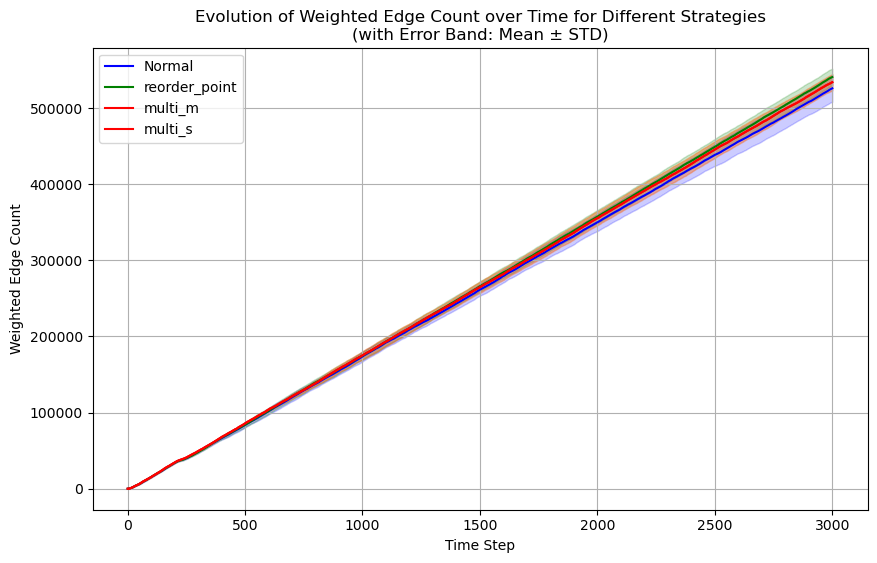

In [20]:
#logistics frozen

change_schedule_A = {
    200: {"logistics_speed": 0.5}
}
change_schedule_B = {
    200: {"logistics_speed": 0.5},
    1000: {"rm_procurement_mode": "reorder_point"}
}
change_schedule_C = {
    200: {"logistics_speed": 0.5},
    1000: {"product_order_mode":"multi_m"}
}
change_schedule_D = {
    200: {"logistics_speed": 0.5},
    1000: {"maerial_order_mode":"multi_s"}
}

total_steps = 3000

# 分别运行 4 个不同场景
results_A = run_scenario("Strategy A", change_schedule_A)
results_B = run_scenario("Strategy B", change_schedule_B)
results_C = run_scenario("Strategy C", change_schedule_C)
results_D = run_scenario("Strategy D", change_schedule_D)

time_steps = np.arange(1, total_steps + 1)

# 从各个策略的 simulation 返回结果中提取 weighted edge count 的均值和标准差
# 假设 run_scenario 返回的结果格式为：
# (mean_cap, mean_prod_ratio, mean_statusN, mean_unit_cost, mean_edge_series, std_edge_series)
mean_edge_series_A = results_A[2]
std_edge_series_A = results_A[3]

mean_edge_series_B = results_B[2]
std_edge_series_B = results_B[3]

mean_edge_series_C = results_C[2]
std_edge_series_C = results_C[3]

mean_edge_series_D = results_D[2]
std_edge_series_D = results_D[3]

plt.figure(figsize=(10, 6))

# 绘制 Strategy A 的曲线和误差带
plt.plot(time_steps, mean_edge_series_A, label="Normal", color="blue")
plt.fill_between(time_steps,
                 mean_edge_series_A - std_edge_series_A,
                 mean_edge_series_A + std_edge_series_A,
                 color="blue", alpha=0.2)

# 绘制 Strategy B 的曲线和误差带
plt.plot(time_steps, mean_edge_series_B, label="reorder_point", color="green")
plt.fill_between(time_steps,
                 mean_edge_series_B - std_edge_series_B,
                 mean_edge_series_B + std_edge_series_B,
                 color="green", alpha=0.2)

# 绘制 Strategy C 的曲线和误差带
plt.plot(time_steps, mean_edge_series_C, label="multi_m", color="red")
plt.fill_between(time_steps,
                 mean_edge_series_C - std_edge_series_C,
                 mean_edge_series_C + std_edge_series_C,
                 color="red", alpha=0.2)

# 绘制 Strategy D 的曲线和误差带
plt.plot(time_steps, mean_edge_series_C, label="multi_s", color="red")
plt.fill_between(time_steps,
                 mean_edge_series_C - std_edge_series_C,
                 mean_edge_series_C + std_edge_series_C,
                 color="orange", alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Evolution of Weighted Edge Count over Time for Different Strategies\n(with Error Band: Mean ± STD)")
plt.legend()
plt.grid(True)
plt.show()

Running scenario: Strategy A
—— Per-Phase Metrics for Strategy A ——
 Step   200:   Ratio = 4.817,   UnitCost = 95.799,   Completed = 34950.0
 Step  3000:   Ratio = 36.319,   UnitCost = 810.632,   Completed = 588707.0
Running scenario: Strategy B
—— Per-Phase Metrics for Strategy B ——
 Step   200:   Ratio = 6.839,   UnitCost = 140.891,   Completed = 32867.0
 Step  1000:   Ratio = 33.744,   UnitCost = 754.680,   Completed = 162351.0
 Step  3000:   Ratio = 39.801,   UnitCost = 832.978,   Completed = 447168.0
Running scenario: Strategy C
—— Per-Phase Metrics for Strategy C ——
 Step   200:   Ratio = 5.677,   UnitCost = 109.523,   Completed = 34400.0
 Step  1000:   Ratio = 33.370,   UnitCost = 740.515,   Completed = 163547.0
 Step  3000:   Ratio = 113.802,   UnitCost = 894.932,   Completed = 421659.0
Running scenario: Strategy D
—— Per-Phase Metrics for Strategy D ——
 Step   200:   Ratio = 5.261,   UnitCost = 102.370,   Completed = 34196.0
 Step  1000:   Ratio = 33.177,   UnitCost = 714.027,

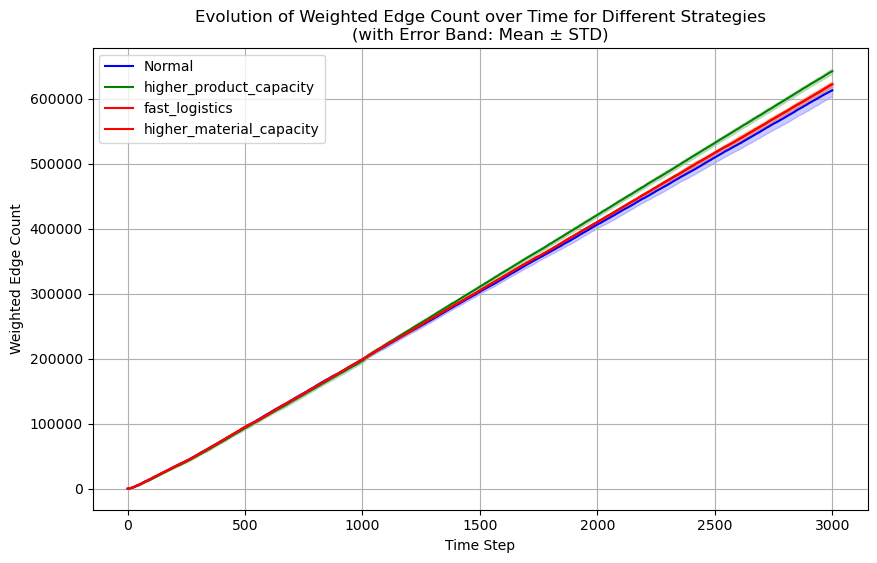

In [21]:
#demand increase

change_schedule_A = {
    200: {"cust_demand_multiplier": 3}
}
change_schedule_B = {
    200: {"cust_demand_multiplier": 3},
    1000: {"m_production_capacity": 100}
}
change_schedule_C = {
    200: {"cust_demand_multiplier": 3},
    1000: {"logistics_speed":6}
}
change_schedule_D = {
    200: {"cust_demand_multiplier": 3},
    1000: {"s_material_capacity":1500}
}


total_steps = 3000

# 分别运行 4 个不同场景
results_A = run_scenario("Strategy A", change_schedule_A)
results_B = run_scenario("Strategy B", change_schedule_B)
results_C = run_scenario("Strategy C", change_schedule_C)
results_D = run_scenario("Strategy D", change_schedule_D)

time_steps = np.arange(1, total_steps + 1)

# 从各个策略的 simulation 返回结果中提取 weighted edge count 的均值和标准差
# 假设 run_scenario 返回的结果格式为：
# (mean_cap, mean_prod_ratio, mean_statusN, mean_unit_cost, mean_edge_series, std_edge_series)
mean_edge_series_A = results_A[2]
std_edge_series_A = results_A[3]

mean_edge_series_B = results_B[2]
std_edge_series_B = results_B[3]

mean_edge_series_C = results_C[2]
std_edge_series_C = results_C[3]

mean_edge_series_D = results_D[2]
std_edge_series_D = results_D[3]

plt.figure(figsize=(10, 6))

# 绘制 Strategy A 的曲线和误差带
plt.plot(time_steps, mean_edge_series_A, label="Normal", color="blue")
plt.fill_between(time_steps,
                 mean_edge_series_A - std_edge_series_A,
                 mean_edge_series_A + std_edge_series_A,
                 color="blue", alpha=0.2)

# 绘制 Strategy B 的曲线和误差带
plt.plot(time_steps, mean_edge_series_B, label="higher_product_capacity", color="green")
plt.fill_between(time_steps,
                 mean_edge_series_B - std_edge_series_B,
                 mean_edge_series_B + std_edge_series_B,
                 color="green", alpha=0.2)

# 绘制 Strategy C 的曲线和误差带
plt.plot(time_steps, mean_edge_series_C, label="fast_logistics", color="red")
plt.fill_between(time_steps,
                 mean_edge_series_C - std_edge_series_C,
                 mean_edge_series_C + std_edge_series_C,
                 color="red", alpha=0.2)

# 绘制 Strategy D 的曲线和误差带
plt.plot(time_steps, mean_edge_series_C, label="higher_material_capacity", color="red")
plt.fill_between(time_steps,
                 mean_edge_series_C - std_edge_series_C,
                 mean_edge_series_C + std_edge_series_C,
                 color="orange", alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Evolution of Weighted Edge Count over Time for Different Strategies\n(with Error Band: Mean ± STD)")
plt.legend()
plt.grid(True)
plt.show()